In [118]:
import numpy as np
import io_mesh as io
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
def calculate_area(surfname,fwhm):
    """calculate surface area using minctools"""
    try:
        subprocess.call("depth_potential -area_voronoi " + surfname + " /tmp/tmp_area.txt",shell=True)
        subprocess.call("depth_potential -smooth " + str(fwhm) + " /tmp/tmp_area.txt " + surfname + " /tmp/sm_area.txt",shell=True)
        area=np.loadtxt("/tmp/sm_area.txt")
        subprocess.call("rm /tmp/sm_area.txt /tmp/tmp_area.txt",shell=True)
    except OSError:
        print("depth_potential not found, please install CIVET tools or replace with alternative area calculation/data smoothing")
        return 0;
    return area;

def beta(alpha, aw, ap):
    """Compute euclidean distance fraction, beta, that will yield the desired
    volume fraction, alpha, given vertex areas in the white matter surface, aw,
    and on the pial surface, ap.

    A surface with `alpha` fraction of the cortical volume below it and 
    `1 - alpha` fraction above it can then be constructed from pial, px, and 
    white matter, pw, surface coordinates as `beta * px + (1 - beta) * pw`.
    """
    if alpha == 0:
        return np.zeros_like(aw)
    elif alpha == 1:
        return np.ones_like(aw)
    else:
        return 1-(1 / (ap - aw) * (-aw + np.sqrt((1-alpha)*ap**2 + alpha*aw**2)))

def rho(alpha, aw, ap):
    """Compute equivolumetric distance fraction, rho from the euclidean depth alpha, given vertex areas in the white matter surface, aw,
    and on the pial surface, ap.

    A surface with `alpha` fraction of the cortical volume below it and 
    `1 - alpha` fraction above it can then be constructed from pial, px, and 
    white matter, pw, surface coordinates as `beta * px + (1 - beta) * pw`.
    """
    return (-aw + np.sqrt(alpha * ap**2 + (1-alpha)*aw**2))/(ap-aw)


In [120]:
#import surfaces
fwhm = 2
hemi="left"
prefix="smMarch_surfs_"

NNDir="/data1/users/kwagstyl/bigbrain/NeuralNetworks/Surfaces200218/"
white_surf = NNDir + prefix + hemi + "_layer5.obj"
gray_surf = NNDir + prefix + hemi + "_layer0.obj"

wm = io.load_mesh_geometry(white_surf)
gm = io.load_mesh_geometry(gray_surf)

wm_vertexareas = calculate_area(white_surf, fwhm)
pia_vertexareas = calculate_area(gray_surf, fwhm)


KeyboardInterrupt: 

In [ ]:
#import thickness maps
Thickness=np.zeros((6,len(wm['coords'])))
for n in range(6):
    Thickness[n,:]=np.loadtxt('thickness_'+hemi+'_layer'+str(n+1)+'.txt')


In [ ]:
Total=np.sum(Thickness,axis=0)
Fractional=Thickness/Total

In [ ]:
equi_depth=np.zeros((6,len(wm['coords'])))
fractional_depth=np.zeros((6,len(wm['coords'])))
equi_thickness=np.zeros((6,len(wm['coords'])))

for n in range(6):
    fractional_depth[n]=np.sum(Fractional[:n+1,:],axis=0)
    equi_depth[n,:]=rho(fractional_depth[n],wm_vertexareas,pia_vertexareas)
    if n>0:
        equi_thickness[n,:] = equi_depth[n,:] - equi_depth[n-1,:]
    else:
        equi_thickness[n,:] = equi_depth[n,:]
    equi_thickness=np.nan_to_num(equi_thickness)
    np.savetxt('equi_thickness'+hemi+'_'+str(n+1)+'.txt', equi_thickness[n,:],fmt='%.4f')
    subprocess.call("depth_potential -smooth " + str(fwhm) + " equi_thickness"+hemi+"_"+str(n+1)+".txt " + white_surf + " smequi_thickness"+hemi+"_"+str(n+1)+".txt",shell=True)



In [ ]:
ratio=np.sum(equi_thickness[1:3],axis=0)/np.sum(equi_thickness[4:],axis=0)

In [ ]:
np.isinf(ratio).any()

In [ ]:
ratio[np.where(np.isnan(ratio))[0]]=0
ratio[np.where(np.isinf(ratio))[0]]=5
ratio=np.nan_to_num(ratio)
np.savetxt('ratio'+hemi+'.txt', ratio,fmt='%.4f')
subprocess.call("depth_potential -smooth " + str(5) + " ratio"+hemi+".txt " + white_surf + " smratio"+hemi+".txt",shell=True)


In [62]:
fractional_depth[:,0]

array([0.10656849, 0.1886069 , 0.4231239 , 0.48296141, 0.70419902,
       1.        ])

In [69]:
equi_depth[3,0]

0.49504294396610127

In [125]:
ratio[np.where(ratio>5)[0]]=5


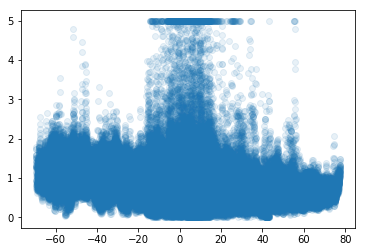

In [130]:
plt.scatter(wm['coords'][:,1],ratio,alpha=0.1)